# hw3 - ensembles

##0 Imports

In [129]:
# !pip install lightgbm==3.2.1
# !pip install catboost

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

## 1 Подготовка данных

Загрузите и предобработайте данные (по своему усмотрению) из hw1

In [2]:
def prepare_for_simple(df):
    df['sex'] = df['sex'].where(df['sex'].isin(["F", "M"]), np.nan)
    df['age'] = df['age'].where((15<= df['age']) & (df['age']<=22), np.nan)
    df.drop("Fedu", axis=1, inplace = True)

    df = df[(df["G3"] != 1) & (df["G3"] != 5) & (df["G3"] != 6) & (df["G3"] != 19) & (df["G3"] != 18)]
    df.loc[:, "age"] = df["age"].fillna(df["age"].mode()[0])
    df.loc[:, "sex"] = df["sex"].fillna(df["sex"].mode()[0])
    df.loc[:, "address"] = df["address"].fillna(df["address"].mode()[0])
    df.reset_index(drop=True, inplace=True)

    enc = OneHotEncoder(sparse_output=False)

    categorical = ["school", "sex", "address", "famsize", "Pstatus",
                "Mjob", "Fjob", "reason","guardian",
                "schoolsup", "famsup", "paid", "activities",
                "nursery", "higher", "internet", "romantic"]
    enc_fea = enc.fit_transform(df[categorical])
    encoded_df = pd.DataFrame(enc_fea, columns=enc.get_feature_names_out(categorical))
    return pd.concat([df.drop(categorical, axis=1), encoded_df], axis=1)


In [178]:
# def prepare_for_GBM(df):
#     df['sex'] = df['sex'].where(df['sex'].isin(["F", "M"]), np.nan)
#     df['age'] = df['age'].where((15<= df['age']) & (df['age']<=22), np.nan)
#     df.drop("Fedu", axis=1, inplace = True)

#     df = df[(df["G3"] != 1) & (df["G3"] != 5) & (df["G3"] != 6) & (df["G3"] != 19) & (df["G3"] != 18)]
#     df.loc[:, "age"] = df["age"].fillna(df["age"].mode()[0])
#     df.loc[:, "sex"] = df["sex"].fillna(df["sex"].mode()[0])
#     df.loc[:, "address"] = df["address"].fillna(df["address"].mode()[0])
#     df.reset_index(drop=True, inplace=True)

#     return df

In [3]:
def prepare_for_d3(df):
    df['sex'] = df['sex'].where(df['sex'].isin(["F", "M"]), np.nan)
    df['age'] = df['age'].where((15<= df['age']) & (df['age']<=22), np.nan)
    df.drop("Fedu", axis=1, inplace = True)

    df.loc[:, "sex"] = df["sex"].fillna(df["sex"].mode()[0])
    df.loc[:, "address"] = df["address"].fillna(df["address"].mode()[0])
    df = df[(df["G3"] != 1) & (df["G3"] != 5) & (df["G3"] != 6) & (df["G3"] != 19) & (df["G3"] != 18)]
    df.reset_index(drop=True, inplace=True)

    enc = OneHotEncoder(sparse_output=False)

    categorical = ["school", "sex", "address", "famsize", "Pstatus",
                "Mjob", "Fjob", "reason","guardian",
                "schoolsup", "famsup", "paid", "activities",
                "nursery", "higher", "internet", "romantic"]
    enc_fea = enc.fit_transform(df[categorical])
    encoded_df = pd.DataFrame(enc_fea, columns=enc.get_feature_names_out(categorical))
    return pd.concat([df.drop(categorical, axis=1), encoded_df], axis=1)

In [180]:
data = pd.read_csv('train_features_with_answers.csv')

df_simple = prepare_for_simple(data.copy())
df_d3 = prepare_for_d3(data.copy())
# df_gbm = prepare_for_GBM(data.copy())

In [5]:
X = df_simple.drop("G3", axis=1)
y = df_simple["G3"]
print(X.shape, y.shape)

(443, 55) (443,)


In [6]:
X_d3 = df_d3.drop("G3", axis=1)
y_d3 = df_d3["G3"]
print(X_d3.shape, y_d3.shape)

(443, 55) (443,)


In [7]:
X_test = pd.read_csv('X_test.csv')
X_test.drop("Fedu", axis=1, inplace=True)
enc = OneHotEncoder(sparse_output=False)
categorical = ["school", "sex", "address", "famsize", "Pstatus",
               "Mjob", "Fjob", "reason","guardian",
               "schoolsup", "famsup", "paid", "activities",
               "nursery", "higher", "internet", "romantic"]
enc_fea = enc.fit_transform(X_test[categorical])
encoded_df = pd.DataFrame(enc_fea, columns=enc.get_feature_names_out(categorical))
df_encoded = pd.concat([X_test.drop(categorical, axis=1), encoded_df], axis=1)
X_test = df_encoded.copy()
print(X_test.shape)

(195, 55)


In [181]:
# X_gbm = df_gbm.drop("G3", axis=1)
# y_gbm = df_gbm["G3"]
# print(X_gbm.shape, y_gbm.shape)
# X_test_gbm = pd.read_csv('X_test.csv')
# X_test_gbm.drop("Fedu", axis=1, inplace=True)
# print(X_test_gbm.shape)

(443, 29) (443,)
(195, 29)


## 2 Обоснуйте выбор слабых (базовых) алгоритмов

Возьмем:
*   SVM (хорошо показал себя в hw1)
*   KNN (хорошо показал себя в hw1)
*   DecisionTreeClassifier (должен хорошо справиться с задачей классификации, пусть даже переобучится, в ансамбле, когда смешаем его с другими моделями будет хорошо по итогу) + можем спокойно скормить ему выборку с пропусками


In [8]:
%%time
#параметры пока подбираем независимо для каждого алгоритма (по cross_val_score)
# просто чтобы примерно понимать где дальше оптимальные искать (а может и не искать дальше:) )

d3 = DecisionTreeClassifier(random_state=42)

param_grid = {
    "max_depth": np.arange(2, 12),
    "max_features": np.arange(20, X_d3.shape[1])
}

search = GridSearchCV(d3, param_grid, n_jobs=-1, cv=5).fit(X_d3, y_d3)
print("Best parameter (score=%0.3f):" % search.best_score_)
print("max_depth :", search.best_params_["max_depth"])
print("max_features :", search.best_params_["max_features"])

Best parameter (score=0.226):
max_depth : 2
max_features : 31
CPU times: user 1.29 s, sys: 129 ms, total: 1.42 s
Wall time: 17.2 s


In [15]:
knn = KNeighborsClassifier(n_neighbors=16).fit(X, y) # из hw1
svc = SVC(C=0.5, probability=True, random_state=42).fit(X, y) # из hw1
d3 = DecisionTreeClassifier(max_depth=2, max_features=31, random_state=42).fit(X_d3, y_d3)

print(np.mean(cross_val_score(knn, X, y)))
print(np.mean(cross_val_score(svc, X, y)))
print(np.mean(cross_val_score(d3, X_d3, y_d3)))

0.16241062308478038
0.16475995914198163
0.22566394279877425


In [18]:
# for i in range(30, 44):
#     print(max(knn.predict_proba(X)[i, :]))
#     print(max(svc.predict_proba(X)[i, :]))
#     print(max(d3.predict_proba(X_d3)[i, :]))
#     print("---------------------")

In [10]:
# Получим предсказания
pred_knn = knn.predict(X)
pred_svc = svc.predict(X)
pred_d3 = d3.predict(X_d3)

# Создадим DataFrame для предсказаний
predictions_df = pd.DataFrame({
    'KNN': pred_knn,
    'SVC': pred_svc,
    'd3': pred_d3
})
# Вычислим корреляцию между предсказаниями
correlation_matrix = predictions_df.corr()
print(correlation_matrix)

          KNN       SVC        d3
KNN  1.000000  0.246185  0.432957
SVC  0.246185  1.000000  0.257595
d3   0.432957  0.257595  1.000000


## 3 Постройте решение на основе подхода Blending

Правила:
- Нужно использовать вероятности
- Предложите что-то лучше, чем брать среднее от предсказаний моделей (оценивать уверенность алгоритмов, точности и т.д.)
- Заставьте базовые алгоритмы быть некорелированными
- Добавьте рандома (например, стройте ваши алгоритмы на разных выборках, по разному предобрабатывайте данные или применяйте для разных признаков соответствующие алгоритмы ... )
- Проявите смекалку

🚩❗[IDEA] заметил, что довольно часто уверенность knn в каком-то классе выше, чем у других алгоритмов, при этом d3 показывает лучший cv_score. Поэтому возникает идея попробовать распределить веса так:

* knn - 0.25
* svc - 0.3
* d3 - 0.45

In [61]:
knn = KNeighborsClassifier(n_neighbors=16).fit(X, y)
svc = SVC(C=0.5, probability=True, random_state=42).fit(X, y)
d3 = DecisionTreeClassifier(max_depth=2, max_features=31, random_state=42).fit(X_d3, y_d3)

In [62]:
voting = VotingClassifier(estimators=[('knn', knn), ('svc', svc), ('nb', d3)], voting='soft',
                          weights=[0.25, 0.3, 0.45])
print(np.mean(cross_val_score(voting, X, y, cv=5)))

0.21664964249233912


## 4 Постройте решение на основе подхода Stacking

Правила:
- Реализуйте пайплайн обучения и предсказания (например, sklearn.pipeline или класс)
- Проведите оптимизацию пайплайна
- Оцените вклад каждого базового алгоритма в итоговое предсказание

In [100]:
%%time
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# knn = KNeighborsClassifier(n_neighbors=16)
# svc = SVC(C=0.5, probability=True, random_state=42)
# d3 = DecisionTreeClassifier(max_depth=2, max_features=31, random_state=42)

final_est = DecisionTreeClassifier(random_state=42)

estimators = [
    ('knn', KNeighborsClassifier()),
    ('svc', SVC(probability=True, random_state=42)),
    ('d3', DecisionTreeClassifier(max_features=31, random_state=42))
]

sclf = StackingClassifier(
    estimators=estimators, final_estimator=final_est
)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('stacking', sclf)
])


params = {
    'stacking__final_estimator__max_depth': [3,4],
    'stacking__knn__n_neighbors': np.arange(12, 15),
    'stacking__svc__C': np.arange(0.5, 0.8, 0.1),
    'stacking__d3__max_depth': [2],
}

search = GridSearchCV(pipe, params, n_jobs=-2, scoring='accuracy').fit(X_train, y_train)
# Вывод результатов
print("Лучшие параметры:", search.best_params_)
print("Лучшее значение точности:", search.best_score_)

# Оценка на валидационной выборке
best_pipeline = search.best_estimator_
val_accuracy = best_pipeline.score(X_val, y_val)
print("Точность на валидационной выборке:", val_accuracy)


Лучшие параметры: {'stacking__d3__max_depth': 2, 'stacking__final_estimator__max_depth': 3, 'stacking__knn__n_neighbors': 13, 'stacking__svc__C': 0.6}
Лучшее значение точности: 0.2288128772635815
Точность на валидационной выборке: 0.24719101123595505
CPU times: user 55.3 s, sys: 134 ms, total: 55.4 s
Wall time: 58.5 s


In [162]:
final_est = DecisionTreeClassifier(max_depth=3, random_state=42)

estimators = [
    ('knn', KNeighborsClassifier(n_neighbors=13)),
    ('svc', SVC(C=0.6, probability=True, random_state=42)),
    ('d3', DecisionTreeClassifier(max_depth=2, max_features=31, random_state=42))
]

final_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('stacking', sclf)
]).fit(X, y)

stacking = final_pipe.predict(X_test)
submission = pd.read_csv('sample_submission.csv', index_col='id')
submission['G3'] = stacking # ваше предсказание
submission.to_csv('submission_hw3_stacking.csv', index=False)

In [163]:
submission_hw1 = pd.read_csv('submission.csv')

<Axes: xlabel='G3', ylabel='Density'>

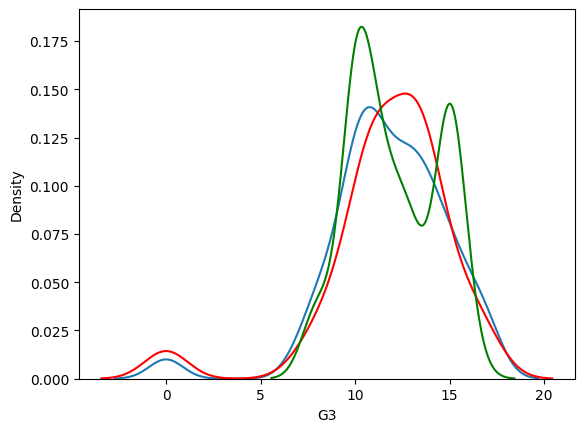

In [164]:
sns.kdeplot(y)
sns.kdeplot(stacking, color="r")
sns.kdeplot(np.array(submission_hw1["G3"]), color="g")

## * Доп задание (не обязательно, но решение будет поощряться)

Правила:
- Постройте несколько сильных алгоритмов разного класса (это может быть бустинг, нейросеть, ансамбль слабых алгоритмов, алгоритм на статистике, что придумаете)
- Реализуйте "управляющий" алгоритм, который на основе входных данных будет выбирать, какой из  сильных алгоритмов запустить (не на основе их работы, а именно на основе данных)

✔ Хочется потыкаться в бустинг

⏩⏩⏩ GradientBoostingClassifier from sklearn ⏪⏪⏪

In [188]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [189]:
%%time
GBM = GradientBoostingClassifier(random_state=42)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('boosting', GBM)
])


params = {
    'boosting__n_estimators': np.arange(30, 39),
    #'boosting__learning_rate': np.arange(0.08, 0.13, 0.01),
    #'boosting__max_depth': np.arange(2, 4)
}

search = GridSearchCV(pipe, params, n_jobs=-2, scoring='accuracy').fit(X_train, y_train)
# Вывод результатов
print("Лучшие параметры:", search.best_params_)
print("Лучшее значение точности:", search.best_score_)

# Оценка на валидационной выборке
best_pipeline = search.best_estimator_
val_accuracy = best_pipeline.score(X_val, y_val)
print("Точность на валидационной выборке:", val_accuracy)


Лучшие параметры: {'boosting__n_estimators': 35}
Лучшее значение точности: 0.1805633802816901
Точность на валидационной выборке: 0.24719101123595505
CPU times: user 37.8 s, sys: 109 ms, total: 37.9 s
Wall time: 41.1 s


<Axes: xlabel='G3', ylabel='Density'>

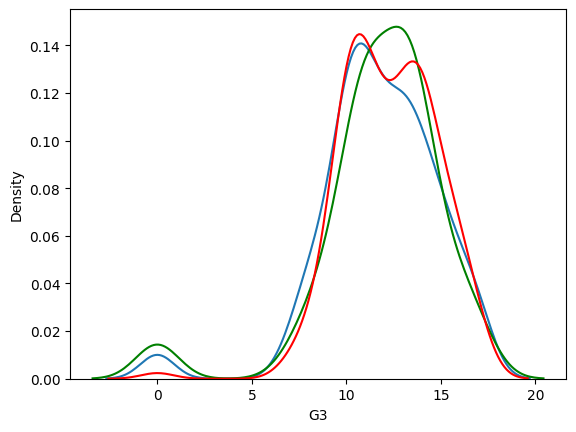

In [190]:
GBM = GradientBoostingClassifier(random_state=42)

pipe_sklearnGBM = Pipeline([
    ('scaler', StandardScaler()),
    ('boosting', GradientBoostingClassifier(n_estimators=35, random_state=42))
]).fit(X, y)

sklearnGBM = pipe_sklearnGBM.predict(X_test)
submission = pd.read_csv('sample_submission.csv', index_col='id')
submission['G3'] = sklearnGBM # ваше предсказание
submission.to_csv('submission_hw3_sklearnGBM.csv', index=False)

sns.kdeplot(y)
sns.kdeplot(stacking, color="g")
sns.kdeplot(sklearnGBM, color="r")

⏩⏩⏩ LGBMClassifier ⏪⏪⏪

In [197]:
#------------------боремся с дисбалансом классов-------------------

# from imblearn.over_sampling import RandomOverSampler

# # Создание экземпляра RandomOverSampler
# ros = RandomOverSampler()

# # Применение увеличения выборки к данным
# X_resampled, y_resampled = ros.fit_resample(X, y)

from imblearn.over_sampling import ADASYN

# Создание экземпляра ADASYN
adasyn = ADASYN()

# Применение ADASYN к данным
X_resampled, y_resampled = adasyn.fit_resample(X, y)

print(X_resampled.shape, y_resampled.shape)

(840, 55) (840,)


In [208]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [211]:
%%time
# Create an instance of the LightGBM classifier
lgbm = lgb.LGBMClassifier(objective="multiclass", num_class=12, random_state=42)

param_grid = {
    "min_data_in_leaf": np.arange(17, 22),
    "max_depth": np.arange(2, 4),
    "subsample": np.arange(0.01, 0.03, 0.01),
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 10],
    'max_bin': [50, 20],
    'num_iterations': [250, 500]
}

search = GridSearchCV(lgbm, param_grid, cv=5, scoring="accuracy").fit(X_train, y_train)

# Вывод результатов
print("Лучшие параметры:", search.best_params_)
print("Лучшее значение точности:", search.best_score_)

# Оценка на валидационной выборке
best_pipeline = search.best_estimator_
val_accuracy = best_pipeline.score(X_val, y_val)
print("Точность на валидационной выборке:", val_accuracy)

[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


<Axes: xlabel='G3', ylabel='Density'>

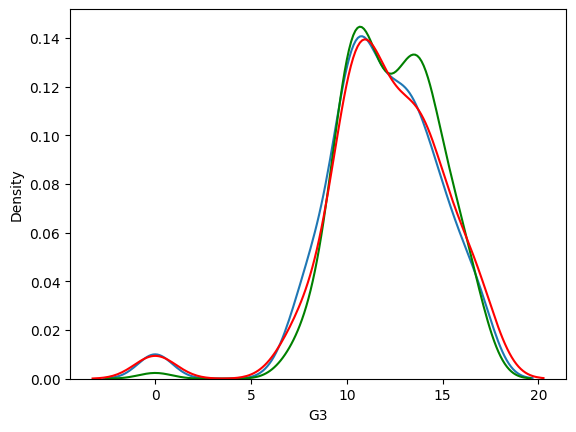

In [217]:
lgbm = lgb.LGBMClassifier(
    objective="multiclass",
    min_data_in_leaf = 19,
    learning_rate = 0.2,
    max_bin = 50,
    max_depth = 3,
    n_estimators = 50,
    num_iterations = 150,
    num_leaves = 7,
    subsample = 0.03,
    random_state=42
)

pipe_lgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('boosting', lgbm)
]).fit(X_resampled, y_resampled)

pred_lgbm = pipe_lgbm.predict(X_test)
submission = pd.read_csv('sample_submission.csv', index_col='id')
submission['G3'] = pred_lgbm # ваше предсказание
submission.to_csv('submission_hw3_lgbm.csv', index=False)

sns.kdeplot(y)
sns.kdeplot(sklearnGBM, color="g")
sns.kdeplot(pred_lgbm, color="r")

⏩⏩⏩ CatBoostClassifier ⏪⏪⏪

In [233]:
%%time
cbc = CatBoostClassifier(
    random_state = 42,
    bootstrap_type = "MVS",
    max_depth = 3,
    subsample = 1,
    min_data_in_leaf = 1,
    task_type="CPU"
)

parameters = {
    #"max_depth": [2, 3, 4],
    #"subsample": [0.8, 1],
    'iterations': [900, 800, 700],
    #'min_data_in_leaf': [1, 3]
}

search = GridSearchCV(cbc, parameters, cv=5, scoring="accuracy").fit(X_train, y_train,
                                                                     eval_set = (X_val, y_val),
                                                                     logging_level='Silent')

# Вывод результатов
print("Лучшие параметры:", search.best_params_)
print("Лучшее значение точности:", search.best_score_)

# Оценка на валидационной выборке
best_pipeline = search.best_estimator_
val_accuracy = best_pipeline.score(X_val, y_val)
print("Точность на валидационной выборке:", val_accuracy)

Лучшие параметры: {'iterations': 800}
Лучшее значение точности: 0.6741404090657822
Точность на валидационной выборке: 0.7142857142857143
CPU times: user 1min 5s, sys: 5.99 s, total: 1min 11s
Wall time: 50.3 s


<Axes: xlabel='G3', ylabel='Density'>

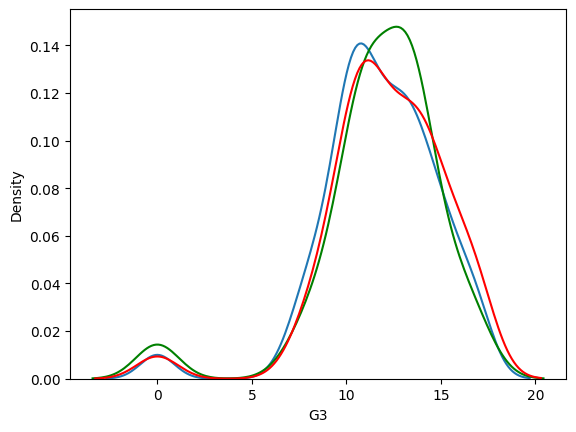

In [237]:
cbc = CatBoostClassifier(
    random_state = 42,
    bootstrap_type = "MVS",
    max_depth = 3,
    subsample = 1,
    iterations = 800,
    min_data_in_leaf = 1,
    task_type="CPU"
).fit(X_resampled, y_resampled, logging_level='Silent')

# pipe_cbc = Pipeline([
#     ('scaler', StandardScaler()),
#     ('boosting', cbc)
# ]).fit(X_resampled, y_resampled)

pred_cbc = cbc.predict(X_test)
submission = pd.read_csv('sample_submission.csv', index_col='id')
submission['G3'] = pred_cbc[:, 0] # ваше предсказание
submission.to_csv('submission_hw3_CatBoost.csv', index=False)

sns.kdeplot(y)
sns.kdeplot(stacking, color="g")
sns.kdeplot(pred_cbc[:, 0], color="r")